In [1]:
import os
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
filename = '/Users/a1/Desktop/project/pytorch_practice/data/N-CMAPSS_DS02-006.h5'

In [3]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.006749616666666669

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [4]:
print("dev_engines:", np.unique(A_dev[:, 0]))
print("test_engines:",np.unique(A_test[:, 0]))

dev_engines: [ 2.  5. 10. 16. 18. 20.]
test_engines: [11. 14. 15.]


In [5]:
# 입력
eng = A_dev[:, 0].astype(int)
state = A_dev[:, 3].astype(int)

normal_ranges = []
abnormal_ranges = []

start = 0

for i in range(1, len(state)):
    # 구간 종료 조건:
    # 1) state 변화
    # 2) 엔진 변화
    if (state[i] != state[i - 1]) or (eng[i] != eng[i - 1]):
        end = i - 1
        if state[start] == 1:
            normal_ranges.append((start, end))
        else:
            abnormal_ranges.append((start, end))
        start = i

# 마지막 구간 처리
end = len(state) - 1
if state[start] == 1:
    normal_ranges.append((start, end))
else:
    abnormal_ranges.append((start, end))

print("\n=== Range summary (A_dev index) ===")
print(f"Total normal ranges   : {len(normal_ranges)}")
print(f"Total abnormal ranges : {len(abnormal_ranges)}")

print("\nNormal ranges by engine:")
for (s, e) in normal_ranges:
    print(f"  Engine {eng[s]} : [{s}, {e}] (len={e - s + 1})")

print("\nAbnormal ranges by engine:")
for (s, e) in abnormal_ranges:
    print(f"  Engine {eng[s]} : [{s}, {e}] (len={e - s + 1})")


normal_engines   = [2, 5, 10]
abnormal_engines = [16, 18, 20]

K = 300  # 엔진별, 구간별 샘플 수

sampled_dev_idx_list = []

for eng_id in normal_engines:
    for (s, e) in normal_ranges:
        if eng[s] != eng_id:
            continue

        idx = np.arange(s, e + 1)
        T = len(idx)
        if T <= 0:
            continue

        k = min(K, T)
        pos = np.linspace(0, T - 1, num=k)
        pos = np.round(pos).astype(int)
        pos = np.unique(pos)

        if pos.size < k:
            pool = np.setdiff1d(np.arange(T), pos)
            need = k - pos.size
            add = np.round(np.linspace(0, pool.size - 1, num=need)).astype(int)
            pos = np.sort(np.concatenate([pos, pool[add]]))
        else:
            pos = np.sort(pos[:k])

        sampled_dev_idx_list.append(idx[pos])

sampled_dev_idx = np.sort(np.unique(np.concatenate(sampled_dev_idx_list)))

print("\n=== DEV sampling (normal state) ===")
print(f"Target engines : {normal_engines}")
print(f"Samples per range (K) : {K}")

dev_count_by_engine = {e: 0 for e in normal_engines}

for eng_id in normal_engines:
    for (s, e) in normal_ranges:
        if eng[s] != eng_id:
            continue

        T = e - s + 1
        k_used = min(K, T)
        dev_count_by_engine[eng_id] += k_used

        print(
            f"  Engine {eng_id} | range [{s},{e}] "
            f"| range_len={T} | sampled={k_used}"
        )

print("\nDEV sampled count by engine:")
for eng_id, cnt in dev_count_by_engine.items():
    print(f"  Engine {eng_id} : {cnt}")

print(f"\nTotal DEV sampled indices: {len(sampled_dev_idx)}")


sampled_test_idx_list = []

for eng_id in abnormal_engines:
    for (s, e) in abnormal_ranges:
        if eng[s] != eng_id:
            continue

        idx = np.arange(s, e + 1)
        T = len(idx)
        if T <= 0:
            continue

        k = min(K, T)
        pos = np.linspace(0, T - 1, num=k)
        pos = np.round(pos).astype(int)
        pos = np.unique(pos)

        if pos.size < k:
            pool = np.setdiff1d(np.arange(T), pos)
            need = k - pos.size
            add = np.round(np.linspace(0, pool.size - 1, num=need)).astype(int)
            pos = np.sort(np.concatenate([pos, pool[add]]))
        else:
            pos = np.sort(pos[:k])

        sampled_test_idx_list.append(idx[pos])

sampled_test_idx = np.sort(np.unique(np.concatenate(sampled_test_idx_list)))

print("\n=== TEST sampling (abnormal state) ===")
print(f"Target engines : {abnormal_engines}")
print(f"Samples per range (K) : {K}")

test_count_by_engine = {e: 0 for e in abnormal_engines}

for eng_id in abnormal_engines:
    for (s, e) in abnormal_ranges:
        if eng[s] != eng_id:
            continue

        T = e - s + 1
        k_used = min(K, T)
        test_count_by_engine[eng_id] += k_used

        print(
            f"  Engine {eng_id} | range [{s},{e}] "
            f"| range_len={T} | sampled={k_used}"
        )

print("\nTEST sampled count by engine:")
for eng_id, cnt in test_count_by_engine.items():
    print(f"  Engine {eng_id} : {cnt}")

print(f"\nTotal TEST sampled indices: {len(sampled_test_idx)}")



=== Range summary (A_dev index) ===
Total normal ranges   : 6
Total abnormal ranges : 6

Normal ranges by engine:
  Engine 2 : [0, 188862] (len=188863)
  Engine 5 : [853142, 1041691] (len=188550)
  Engine 10 : [1886562, 2074611] (len=188050)
  Engine 16 : [2839273, 3033891] (len=194619)
  Engine 18 : [3604568, 3797856] (len=193289)
  Engine 20 : [4495287, 4688640] (len=193354)

Abnormal ranges by engine:
  Engine 2 : [188863, 853141] (len=664279)
  Engine 5 : [1041692, 1886561] (len=844870)
  Engine 10 : [2074612, 2839272] (len=764661)
  Engine 16 : [3033892, 3604567] (len=570676)
  Engine 18 : [3797857, 4495286] (len=697430)
  Engine 20 : [4688641, 5263446] (len=574806)

=== DEV sampling (normal state) ===
Target engines : [2, 5, 10]
Samples per range (K) : 300
  Engine 2 | range [0,188862] | range_len=188863 | sampled=300
  Engine 5 | range [853142,1041691] | range_len=188550 | sampled=300
  Engine 10 | range [1886562,2074611] | range_len=188050 | sampled=300

DEV sampled count by e

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

selected_indices = [torch.tensor(sampled_dev_idx, device=device)]
selected_indices_test = [torch.tensor(sampled_test_idx, device=device)]

X_list = [torch.tensor(W_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
Y_list = [torch.tensor(X_s_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
x_test_list = [torch.tensor(W_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]
y_test_list = [torch.tensor(X_s_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]

X = torch.cat(X_list, dim=0)        # (N_dev, D)
Y = torch.cat(Y_list, dim=0)        # (N_dev, 14)
x_test = torch.cat(x_test_list, dim=0)   # (N_test, D)
y_test = torch.cat(y_test_list, dim=0)   # (N_test, 14)

x_mean = X.mean(dim=0)
x_var  = X.var(dim=0, unbiased=False)
x_std  = x_var.sqrt()
x_scaled = (X - x_mean) / x_std

y_mean = Y.mean(dim=0)              # (14,)
y_var  = Y.var(dim=0, unbiased=False)
y_std  = y_var.sqrt()               # (14,)
y_scaled = (Y - y_mean) / y_std     # (N_dev, 14)

[INFO] common sampled_idx len = 900

=== [0] T24 ===
[Value]
MAE  : 0.0113
RMSE : 0.0159
R²   : 0.9997

=== [1] T30 ===
[Value]
MAE  : 0.0161
RMSE : 0.0225
R²   : 0.9995

=== [2] T48 ===
[Value]
MAE  : 0.1010
RMSE : 0.1364
R²   : 0.9815

=== [3] T50 ===
[Value]
MAE  : 0.1744
RMSE : 0.2384
R²   : 0.9453

=== [4] P15 ===
[Value]
MAE  : 0.0024
RMSE : 0.0031
R²   : 1.0000

=== [5] P2 ===
[Value]
MAE  : 0.0015
RMSE : 0.0027
R²   : 1.0000

=== [6] P21 ===
[Value]
MAE  : 0.0024
RMSE : 0.0031
R²   : 1.0000

=== [7] P24 ===
[Value]
MAE  : 0.0050
RMSE : 0.0067
R²   : 1.0000

=== [8] Ps30 ===
[Value]
MAE  : 0.0110
RMSE : 0.0155
R²   : 0.9998

=== [9] P40 ===
[Value]
MAE  : 0.0109
RMSE : 0.0155
R²   : 0.9998

=== [10] P50 ===
[Value]
MAE  : 0.0054
RMSE : 0.0081
R²   : 0.9999

=== [11] Nf ===
[Value]
MAE  : 0.0094
RMSE : 0.0119
R²   : 0.9999

=== [12] Nc ===
[Value]
MAE  : 0.0229
RMSE : 0.0352
R²   : 0.9988

=== [13] Wf ===
[Value]
MAE  : 0.0307
RMSE : 0.0432
R²   : 0.9981


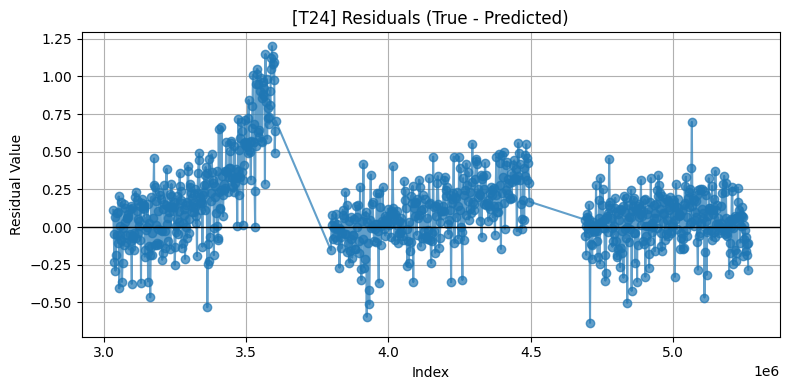

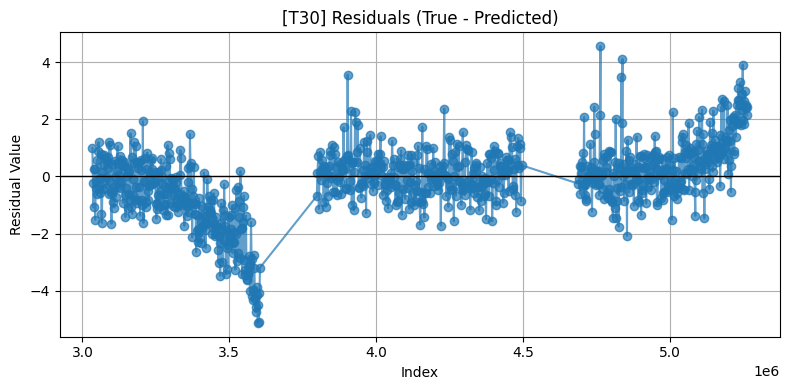

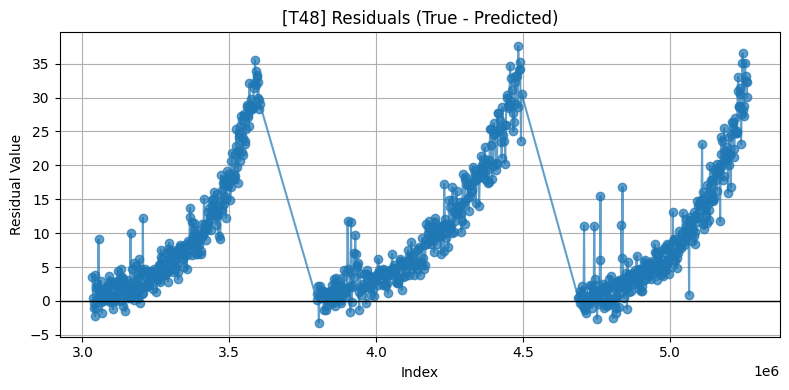

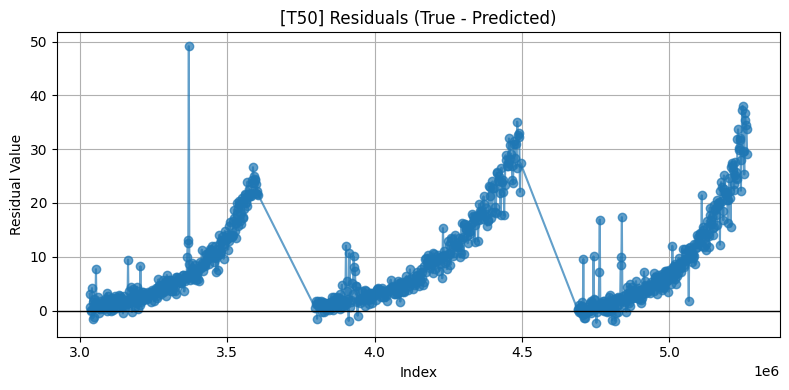

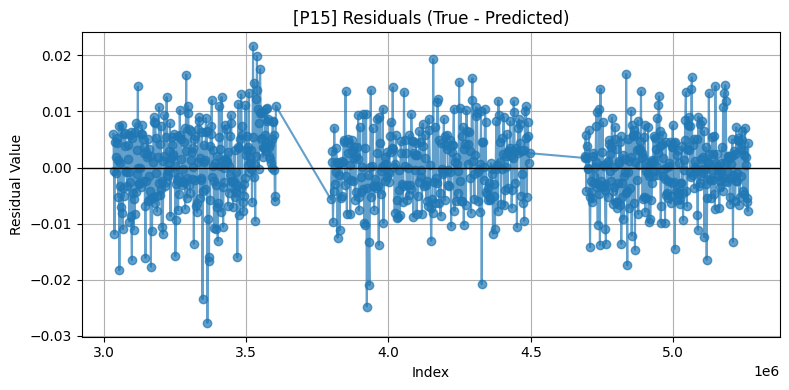

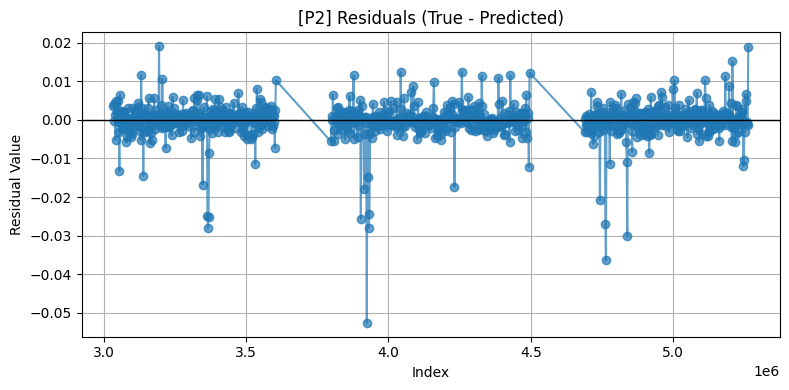

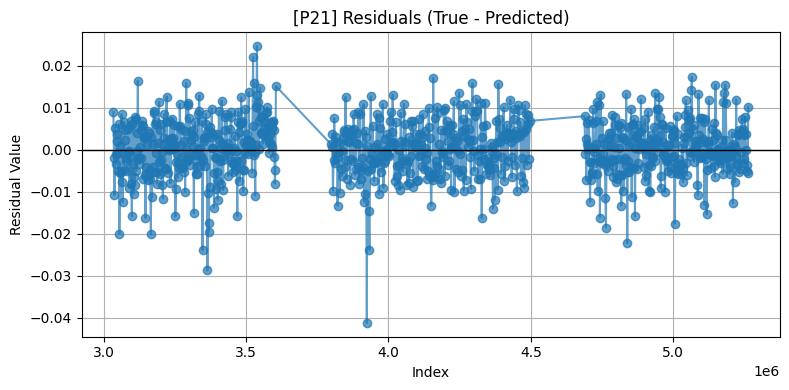

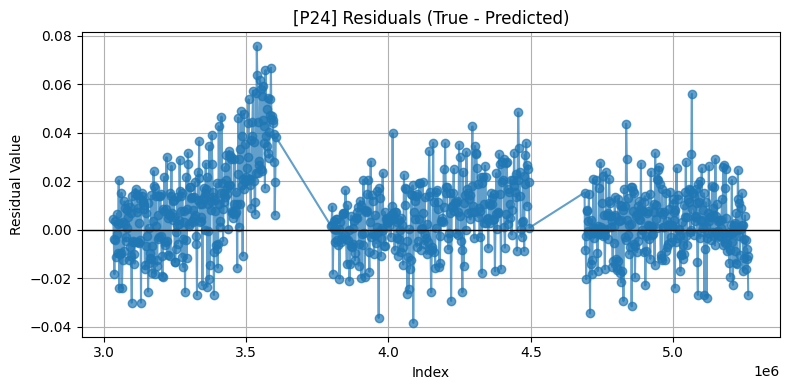

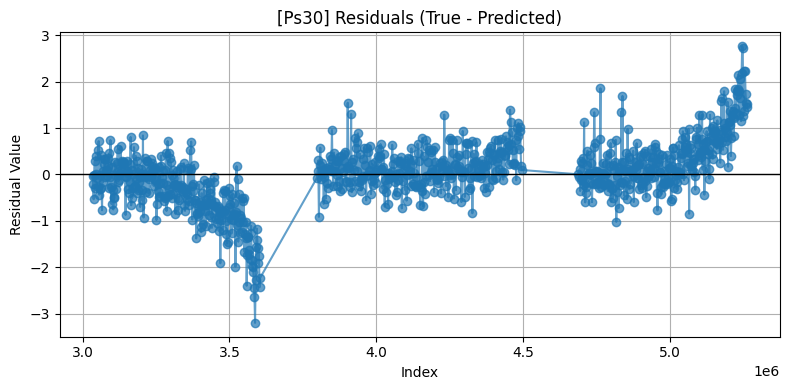

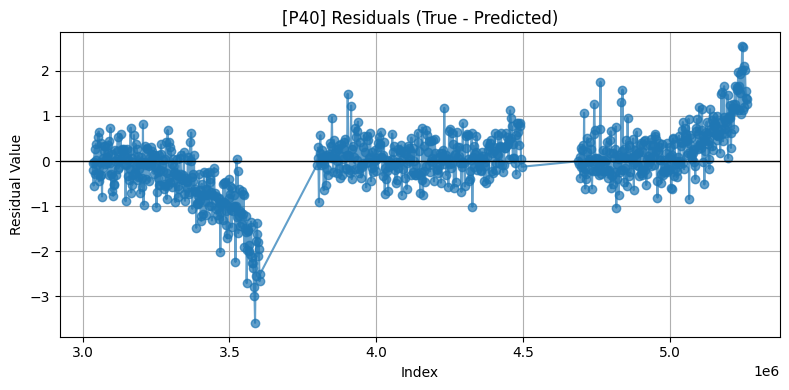

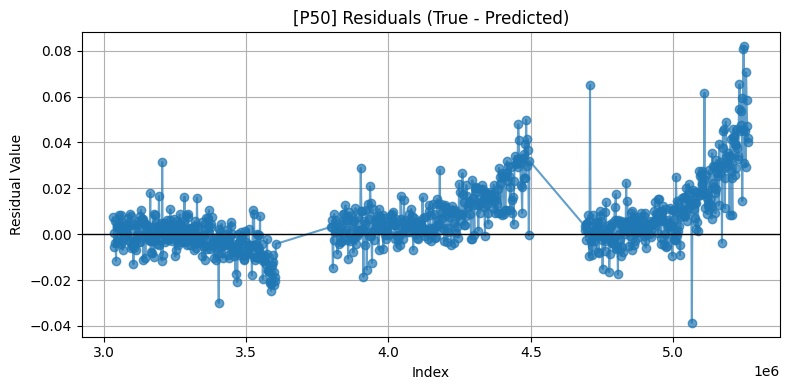

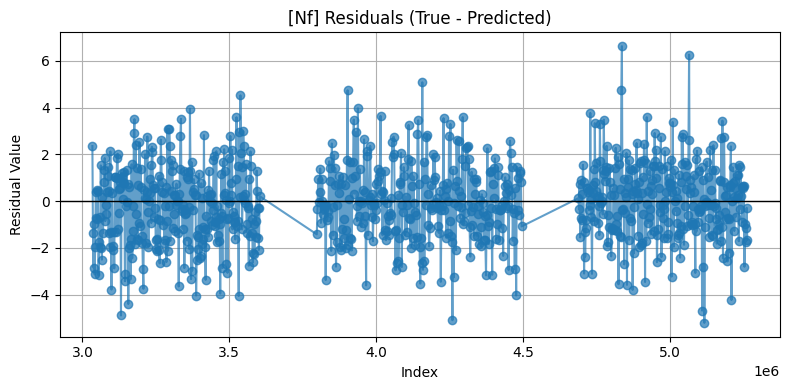

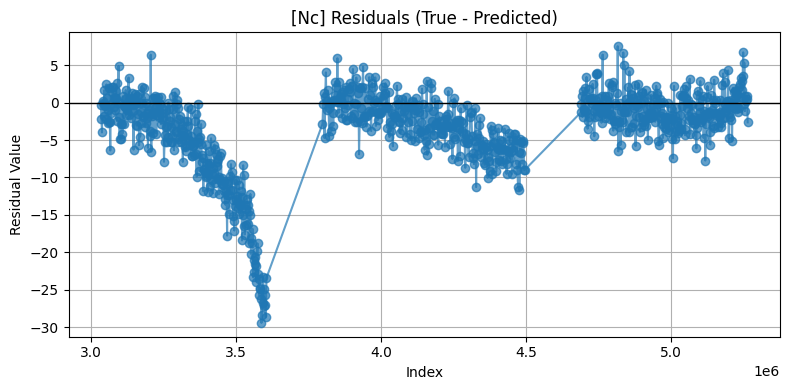

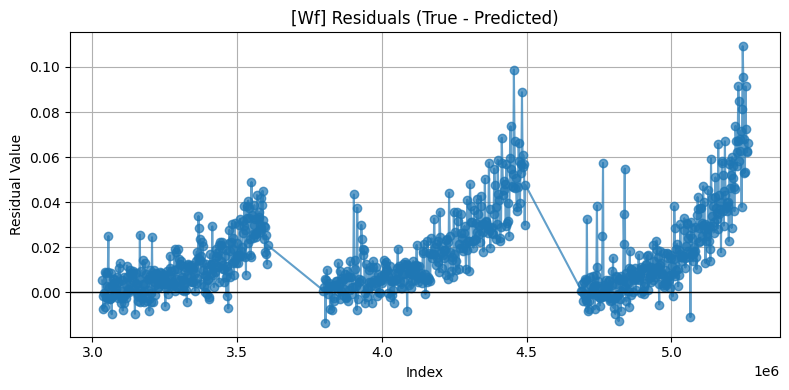

In [7]:
import gpytorch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

output_names = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24',
                'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']

# 0) 잔차 저장용
all_residuals = []
high_r2_list = []
total_all_idx = sampled_test_idx

sampled_idx = sampled_test_idx
# N_sel = min(N, len(total_all_idx))
# sampled_idx = np.random.choice(total_all_idx, size=N_sel, replace=False)
# sampled_idx.sort()
print(f"[INFO] common sampled_idx len = {len(sampled_idx)}")

# =========================================================
# 1) 다출력 GP 모델 정의
# =========================================================
num_tasks = Y.shape[1]   # 14

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # 각 task별 상수 평균 + multitask 구조
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        # 입력 커널(RBF) × task 간 공분산(coregionalization)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(),
            num_tasks=num_tasks,
            rank=2,   # task 공분산 rank (필요시 조정)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)       # (N, num_tasks)
        covar_x = self.covar_module(x)     # Multitask 커널
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# 학습 데이터
train_x = x_scaled.to(device)      # (N_dev, D)
train_y = y_scaled.to(device)      # (N_dev, 14)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=num_tasks
).to(device)

model = MultitaskGPModel(train_x, train_y, likelihood).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# =========================================================
# 2) train (한 번만)
# =========================================================
model.train(); likelihood.train()
num_iters = 100
for i in range(num_iters):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # 필요하면 loss 출력
    # if (i+1) % 10 == 0:
    #     print(f"Iter {i+1}/{num_iters}, loss={loss.item():.4f}")

# =========================================================
# 3) TEST 전체에 대한 다출력 예측 + 지표
# =========================================================
model.eval(); likelihood.eval()

x_test_scaled = (x_test - x_mean) / x_std
x_test_scaled = x_test_scaled.to(device)

y_test_scaled = (y_test - y_mean) / y_std     # (N_test, 14)
y_test_scaled_t = y_test_scaled.to(device)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(x_test_scaled))
    mean_all = preds.mean    # (N_test, 14)

# 출력별 지표 계산
for j, name in enumerate(output_names):
    y_true_j = y_test_scaled_t[:, j].cpu().numpy()
    y_pred_j = mean_all[:, j].cpu().numpy()

    mse  = mean_squared_error(y_true_j, y_pred_j)
    mae  = mean_absolute_error(y_true_j, y_pred_j)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_j, y_pred_j)
    high_r2_list.append({
        "name": name,
        "r2": r2,
    })

    print(f"\n=== [{j}] {name} ===")
    print(f"[Value]")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

# =========================================================
# 4) 공통 인덱스(sampled_idx)에서 잔차 (실제 - 예측) 저장
# =========================================================
# 4-1) 공통 인덱스의 입력
x_sel = torch.tensor(W_dev[sampled_idx], dtype=torch.float32, device=device)
x_sel_scaled = (x_sel - x_mean) / x_std

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_sel = likelihood(model(x_sel_scaled))
    mean_sel_all = preds_sel.mean          # (N_sel, 14)

# 4-2) 출력별 잔차 계산 (언스케일)
for j, name in enumerate(output_names):
    # 실제값 (원 스케일)
    y_true_unscaled = torch.tensor(
        X_s_dev[sampled_idx, j],
        dtype=torch.float32,
        device=device
    )

    # 예측값 (원 스케일로 되돌리기)
    y_pred_unscaled = mean_sel_all[:, j] * y_std[j] + y_mean[j]

    residual = (y_true_unscaled - y_pred_unscaled).detach().cpu().numpy()

    all_residuals.append({
        "name": name,
        "idx": sampled_idx.copy(),
        "residual": residual.copy(),
    })
    # print(f"[STORE] {name} residual saved. N={len(residual)}")
    plt.figure(figsize=(8,4))
    plt.plot(sampled_idx, residual, marker='o', linestyle='-', alpha=0.7)
    plt.axhline(0, color='black', linewidth=1)         # baseline
    plt.title(f"[{name}] Residuals (True - Predicted)")
    plt.xlabel("Index")
    plt.ylabel("Residual Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
print("len(all_residuals) =", len(all_residuals))

# 각 변수별 residual/idx 길이 확인
for i, d in enumerate(all_residuals):
    print(f"[{i:02d}] {d['name']}: len(idx)={len(d['idx'])}, len(residual)={len(d['residual'])}")

# (선택) 길이가 서로 다른지 요약
lens = [len(d["residual"]) for d in all_residuals]
print("unique residual lengths =", sorted(set(lens)))

len(all_residuals) = 14
[00] T24: len(idx)=900, len(residual)=900
[01] T30: len(idx)=900, len(residual)=900
[02] T48: len(idx)=900, len(residual)=900
[03] T50: len(idx)=900, len(residual)=900
[04] P15: len(idx)=900, len(residual)=900
[05] P2: len(idx)=900, len(residual)=900
[06] P21: len(idx)=900, len(residual)=900
[07] P24: len(idx)=900, len(residual)=900
[08] Ps30: len(idx)=900, len(residual)=900
[09] P40: len(idx)=900, len(residual)=900
[10] P50: len(idx)=900, len(residual)=900
[11] Nf: len(idx)=900, len(residual)=900
[12] Nc: len(idx)=900, len(residual)=900
[13] Wf: len(idx)=900, len(residual)=900
unique residual lengths = [900]


In [9]:
signal_names = []
residual_matrix = []

for r in all_residuals:
    signal_names.append(r["name"])
    residual_matrix.append(r["residual"])

# shape: (num_signals, num_samples)
residual_matrix = np.vstack(residual_matrix)

corr_matrix = np.corrcoef(residual_matrix)

distance_matrix = 1 - np.abs(corr_matrix)

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

D_condensed = squareform(distance_matrix, checks=False)
Z = linkage(D_condensed, method="average")

rho_th = 0.75
dist_th = 1 - rho_th

clusters = fcluster(Z, t=dist_th, criterion="distance")

hi_feature_idx = []

for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    hi_feature_idx.append(idx[0])   # 임의 선택 (첫 번째)

hi_var_names = [signal_names[i] for i in hi_feature_idx]
selected_residuals = residual_matrix[hi_feature_idx]
print(hi_var_names)

['T24', 'P15', 'Nf', 'T48', 'T30', 'P50', 'P2']


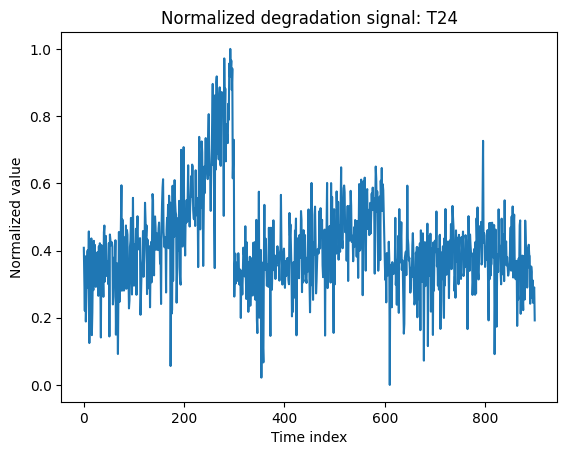

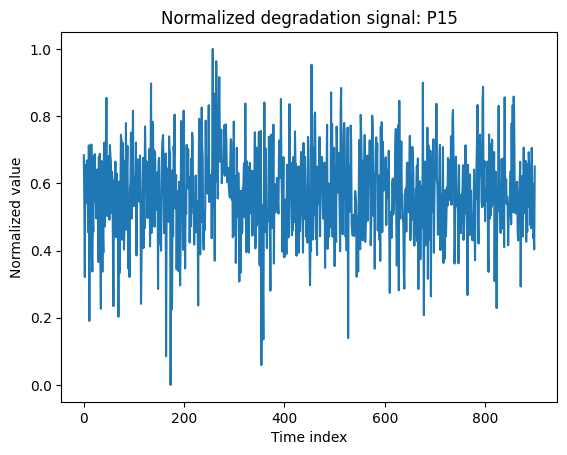

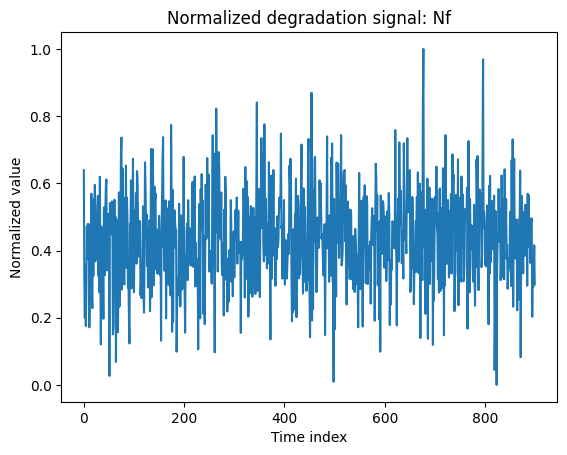

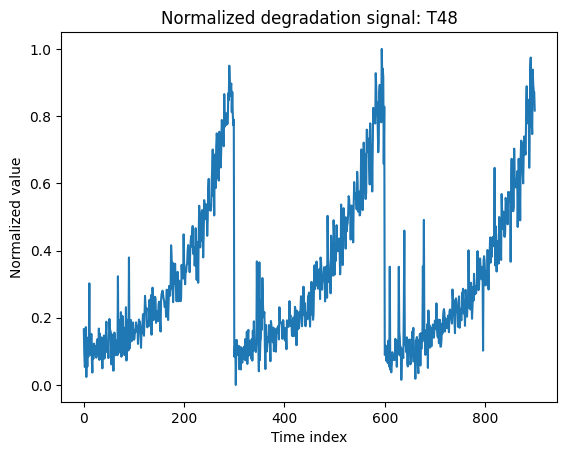

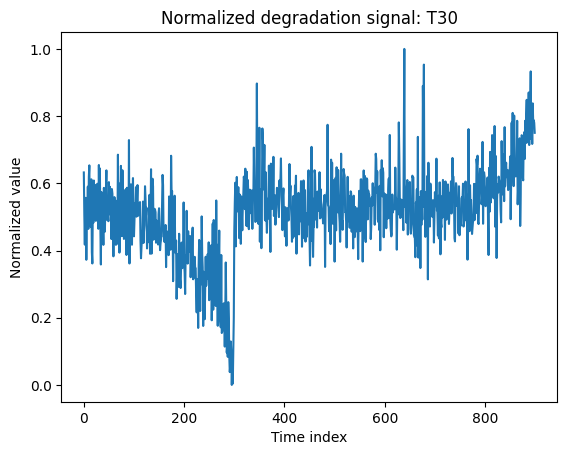

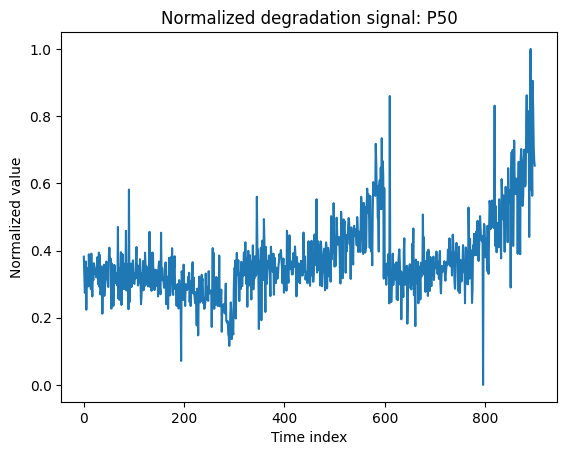

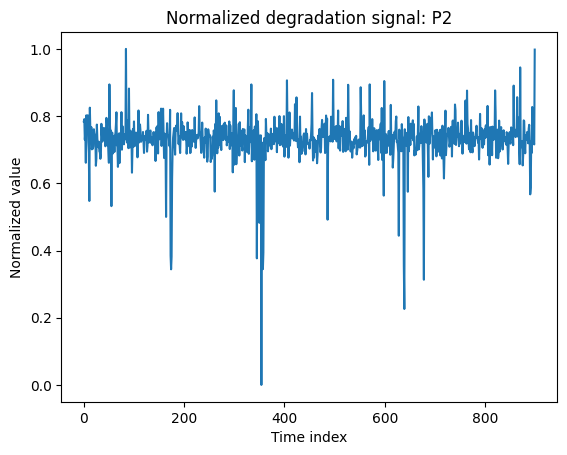

In [10]:
X = selected_residuals

X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)

X_norm = (X - X_min) / (X_max - X_min + 1e-8)

num_signals = X_norm.shape[0]
t = np.arange(X_norm.shape[1])

for i in range(num_signals):
    plt.figure()
    plt.plot(t, X_norm[i])
    plt.xlabel("Time index")
    plt.ylabel("Normalized value")
    plt.title(f"Normalized degradation signal: {hi_var_names[i]}")
    plt.show()


In [ ]:
print(X_norm.shape)

(7, 900)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Activation Functions
class TanhActivation:
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output ** 2)

class LinearActivation:
    def forward(self, x):
        self.output = x
        return self.output
    
    def backward(self, grad_output):
        return grad_output

# Dense Layer
class DenseLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.grad_weights = None
        self.grad_bias = None
        self.input = None
    
    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        grad_input = np.dot(grad_output, self.weights.T)
        return grad_input

# Neural Network Model
class NeuralDataFusionModel:
    def __init__(self, input_dim):
        self.layer1 = DenseLayer(input_dim, 5)
        self.activation1 = TanhActivation()
        self.layer2 = DenseLayer(5, 3)
        self.activation2 = TanhActivation()
        self.layer3 = DenseLayer(3, 1)
        self.activation3 = LinearActivation()
        
        self.parameters = [
            self.layer1.weights, self.layer1.bias,
            self.layer2.weights, self.layer2.bias,
            self.layer3.weights, self.layer3.bias
        ]
        self.gradients = []
    
    def forward(self, x):
        out = self.layer1.forward(x)
        out = self.activation1.forward(out)
        out = self.layer2.forward(out)
        out = self.activation2.forward(out)
        out = self.layer3.forward(out)
        out = self.activation3.forward(out)
        return out
    
    def backward(self, grad_output):
        grad = self.activation3.backward(grad_output)
        grad = self.layer3.backward(grad)
        grad = self.activation2.backward(grad)
        grad = self.layer2.backward(grad)
        grad = self.activation1.backward(grad)
        grad = self.layer1.backward(grad)
        
        self.gradients = [
            self.layer1.grad_weights, self.layer1.grad_bias,
            self.layer2.grad_weights, self.layer2.grad_bias,
            self.layer3.grad_weights, self.layer3.grad_bias
        ]
        return grad

# Delta function
def delta_function(x):
    return (x > 0).astype(float)

# Loss and Gradient Computation with DEBUG
def compute_loss_and_gradients(model, X_norm, K, lambda1=0.001, lambda2=0.001, 
                                window=5, debug=False, epoch=0):
    """
    window: 비교할 구간의 길이 (예: 5)
    """
    num_features, total_samples = X_norm.shape
    N = total_samples // K
    
    loss_term1 = 0.0
    loss_term2 = 0.0
    loss_term3 = 0.0
    
    all_HI = []
    all_inputs = []
    
    if debug:
        print(f"\n{'='*80}")
        print(f"EPOCH {epoch} - LOSS COMPUTATION (Window size: {window})")
        print(f"{'='*80}")
    
    # Forward pass for all engines
    for n in range(N):
        start_idx = n * K
        end_idx = (n + 1) * K
        engine_data = X_norm[:, start_idx:end_idx].T
        all_inputs.append(engine_data)
        
        HI_n = model.forward(engine_data)
        all_HI.append(HI_n)
        
        if debug:
            print(f"\n[Engine {n+1}]")
            print(f"  HI range: [{HI_n.min():.6f}, {HI_n.max():.6f}]")
            print(f"  HI[0] (first): {HI_n[0, 0]:.6f}")
            print(f"  HI[{K-1}] (last, T_n): {HI_n[-1, 0]:.6f}")
        
        # First term
        h_n_Tn = HI_n[-1, 0]
        term1_contribution = (h_n_Tn - 1) ** 2
        loss_term1 += term1_contribution
        
        if debug:
            print(f"  Loss Term 1 contribution: {term1_contribution:.6f}")
        
        # Second term: monotonicity
        T_n = K
        term2_contribution = 0.0
        monotonicity_violations = 0
        
        for t in range(1, T_n):
            d_nt = HI_n[t, 0] - HI_n[t-1, 0]
            exp_d = np.exp(d_nt)
            penalty = max(exp_d - 1, 0)
            term2_contribution += (1.0 / (T_n - 1)) * penalty
            
            if d_nt < 0:
                monotonicity_violations += 1
        
        loss_term2 += term2_contribution
        
        if debug:
            print(f"  Loss Term 2 contribution: {term2_contribution:.6f}")
            print(f"  Monotonicity violations: {monotonicity_violations}/{T_n-1}")
        
        # Third term: convexity with window
        term3_contribution = 0.0
        convexity_violations = 0
        
        for t in range(window, T_n):  # t는 window부터 시작
            # 현재 구간: (t-1, t)의 평균 기울기
            d_nt = HI_n[t, 0] - HI_n[t-1, 0]
            
            # 과거 구간: (t-window-1, t-window)부터 (t-2, t-1)까지의 평균 기울기
            # 또는 단순히 (t-window, t-1)의 평균 기울기
            d_nt_prev = (HI_n[t-1, 0] - HI_n[t-window, 0]) / window
            
            # d_nt가 d_nt_prev보다 커야 함 (가속)
            diff = d_nt - d_nt_prev
            exp_diff = np.exp(-diff)  # diff가 양수면 작은 값, 음수면 큰 값
            penalty = max(exp_diff - 1, 0)
            term3_contribution += (1.0 / (T_n - window)) * penalty
            
            if diff < 0:
                convexity_violations += 1
        
        loss_term3 += term3_contribution
        
        if debug:
            print(f"  Loss Term 3 contribution: {term3_contribution:.6f}")
            print(f"  Convexity violations: {convexity_violations}/{T_n-window}")
            
            # Gradient stats
            diffs = np.diff(HI_n.flatten())
            print(f"  Gradient (dHI/dt) stats:")
            print(f"    Mean: {diffs.mean():.6f}, Std: {diffs.std():.6f}")
    
    total_loss = loss_term1 + lambda1 * loss_term2 + lambda2 * loss_term3
    
    if debug:
        print(f"\n{'='*80}")
        print(f"LOSS BREAKDOWN:")
        print(f"  Term 1 (Target HI=1): {loss_term1:.6f}")
        print(f"  Term 2 (Monotonicity): {loss_term2:.6f} (×{lambda1})")
        print(f"  Term 3 (Convexity): {loss_term3:.6f} (×{lambda2})")
        print(f"  Total Loss: {total_loss:.6f}")
        print(f"{'='*80}")
    
    # Compute gradients
    total_grad_output = []
    
    for n in range(N):
        HI_n = all_HI[n]
        T_n = K
        grad_h = np.zeros_like(HI_n)
        
        # Gradient from first term
        h_n_Tn = HI_n[-1, 0]
        grad_h[-1, 0] += 2 * (h_n_Tn - 1)
        
        # Gradient from second term
        for t in range(1, T_n):
            d_nt = HI_n[t, 0] - HI_n[t-1, 0]
            exp_d = np.exp(d_nt)
            delta_exp = delta_function(exp_d - 1)
            grad_d_nt = (lambda1 / (T_n - 1)) * delta_exp * exp_d
            grad_h[t, 0] += grad_d_nt
            grad_h[t-1, 0] -= grad_d_nt
        
        # Gradient from third term (MODIFIED with window)
        for t in range(window, T_n):
            d_nt = HI_n[t, 0] - HI_n[t-1, 0]
            d_nt_prev = (HI_n[t-1, 0] - HI_n[t-window, 0]) / window
            
            diff = d_nt - d_nt_prev
            exp_diff = np.exp(-diff)
            delta_exp_diff = delta_function(exp_diff - 1)
            
            # ∂L/∂diff
            grad_diff = (lambda2 / (T_n - window)) * delta_exp_diff * exp_diff * (-1)
            
            # Chain rule: diff = d_nt - d_nt_prev
            # d_nt = h(t) - h(t-1)
            # d_nt_prev = [h(t-1) - h(t-window)] / window
            
            # ∂diff/∂h(t) = 1
            grad_h[t, 0] += grad_diff * 1
            
            # ∂diff/∂h(t-1) = -1 - (1/window) = -(1 + 1/window)
            grad_h[t-1, 0] += grad_diff * (-(1 + 1.0/window))
            
            # ∂diff/∂h(t-window) = 1/window
            grad_h[t-window, 0] += grad_diff * (1.0/window)
        
        total_grad_output.append(grad_h)
    
    # Backpropagation
    for n in range(N):
        engine_data = all_inputs[n]
        grad_output = total_grad_output[n]
        _ = model.forward(engine_data)
        model.backward(grad_output)
        
        if n == 0:
            accumulated_grads = [g.copy() for g in model.gradients]
        else:
            for i in range(len(accumulated_grads)):
                accumulated_grads[i] += model.gradients[i]
    
    for i in range(len(accumulated_grads)):
        accumulated_grads[i] /= N
    
    model.gradients = accumulated_grads
    return total_loss

# Adam Optimizer
class AdamOptimizer:
    def __init__(self, parameters, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p) for p in parameters]
        self.v = [np.zeros_like(p) for p in parameters]
        self.t = 0
    
    def step(self, parameters, gradients, debug=False):
        self.t += 1
        
        if debug:
            print(f"\nADAM OPTIMIZER UPDATE (step {self.t}):")
        
        for i in range(len(parameters)):
            g = gradients[i]
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            update = self.alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)
            parameters[i] -= update
            
            if debug and i < 2:  # Only show first 2 parameters
                param_names = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']
                print(f"  {param_names[i]}: update_mean={update.mean():.8f}, update_max_abs={np.abs(update).max():.8f}")

# Training Function with DEBUG
def train_model(X_norm, K, epochs=1000, lambda1=0.001, lambda2=0.001, 
                alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                verbose=True, print_every=100, debug_epochs=None):
    num_features = X_norm.shape[0]
    model = NeuralDataFusionModel(input_dim=num_features)
    optimizer = AdamOptimizer(model.parameters, alpha, beta1, beta2, epsilon)
    loss_history = []
    
    if debug_epochs is None:
        debug_epochs = [1, 10, 50, 100, 500, epochs]
    
    for epoch in range(epochs):
        debug = (epoch + 1) in debug_epochs
        
        loss = compute_loss_and_gradients(model, X_norm, K, lambda1, lambda2, debug=debug, epoch=epoch+1)
        loss_history.append(loss)
        optimizer.step(model.parameters, model.gradients, debug=debug)
        
        if verbose and (epoch + 1) % print_every == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")
    
    return model, loss_history

# Prediction Function
def predict(model, X_norm, K):
    num_features, total_samples = X_norm.shape
    N = total_samples // K
    predictions = []
    
    for n in range(N):
        start_idx = n * K
        end_idx = (n + 1) * K
        engine_data = X_norm[:, start_idx:end_idx].T
        HI_n = model.forward(engine_data)
        predictions.append(HI_n.flatten())
    
    return predictions

In [ ]:
# 모델 학습 (디버그 모드)
# debug_epochs: epochs를 10등분한 지점에서 상세 출력
epochs_total = 1000
debug_epochs = [epochs_total * i // 10 for i in range(1, 11)]  # [100, 200, 300, ..., 1000]

print(f"Debug will be shown at epochs: {debug_epochs}")

model, loss_history = train_model(
    X_norm, 
    K, 
    epochs=epochs_total,
    lambda1=2.1,
    lambda2=3.8,
    alpha=0.001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    verbose=True,
    print_every=100,
    debug_epochs=debug_epochs
)

Debug will be shown at epochs: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

EPOCH 100 - LOSS COMPUTATION
Total engines (N): 3, Cycle length (K): 300

[Engine 1]
  HI range: [0.256136, 0.337526]
  HI[0] (first): 0.311489
  HI[150] (middle): 0.308577
  HI[299] (last, T_n): 0.320077
  Loss Term 1 contribution: 0.462295 (target: h_n(T_n)=1)
  Loss Term 2 contribution: 0.006552
  Monotonicity violations: 150/299 (50.2%)
  Loss Term 3 contribution: 0.011360
  Gradient (dHI/dt) stats:
    Mean: 0.000029, Std: 0.016241
    Min: -0.049877, Max: 0.043983

[Engine 2]
  HI range: [0.253253, 0.338979]
  HI[0] (first): 0.284153
  HI[150] (middle): 0.287550
  HI[299] (last, T_n): 0.323916
  Loss Term 1 contribution: 0.457090 (target: h_n(T_n)=1)
  Loss Term 2 contribution: 0.006222
  Monotonicity violations: 152/299 (50.8%)
  Loss Term 3 contribution: 0.010543
  Gradient (dHI/dt) stats:
    Mean: 0.000133, Std: 0.015302
    Min: -0.056453, Max: 0.047239

[Engine 3]
  HI range: [0.264149, 0.33

In [19]:
 # 예측
predictions = predict(model, X_norm, K)

print(f"\nFinal Loss: {loss_history[-1]:.6f}")
for i, pred in enumerate(predictions):
    print(f"Engine {i+1}: Final HI = {pred[-1]:.6f}")


Final Loss: 0.012545
Engine 1: Final HI = 0.997871
Engine 2: Final HI = 0.997985
Engine 3: Final HI = 0.998032


TypeError: 'float' object cannot be interpreted as an integer

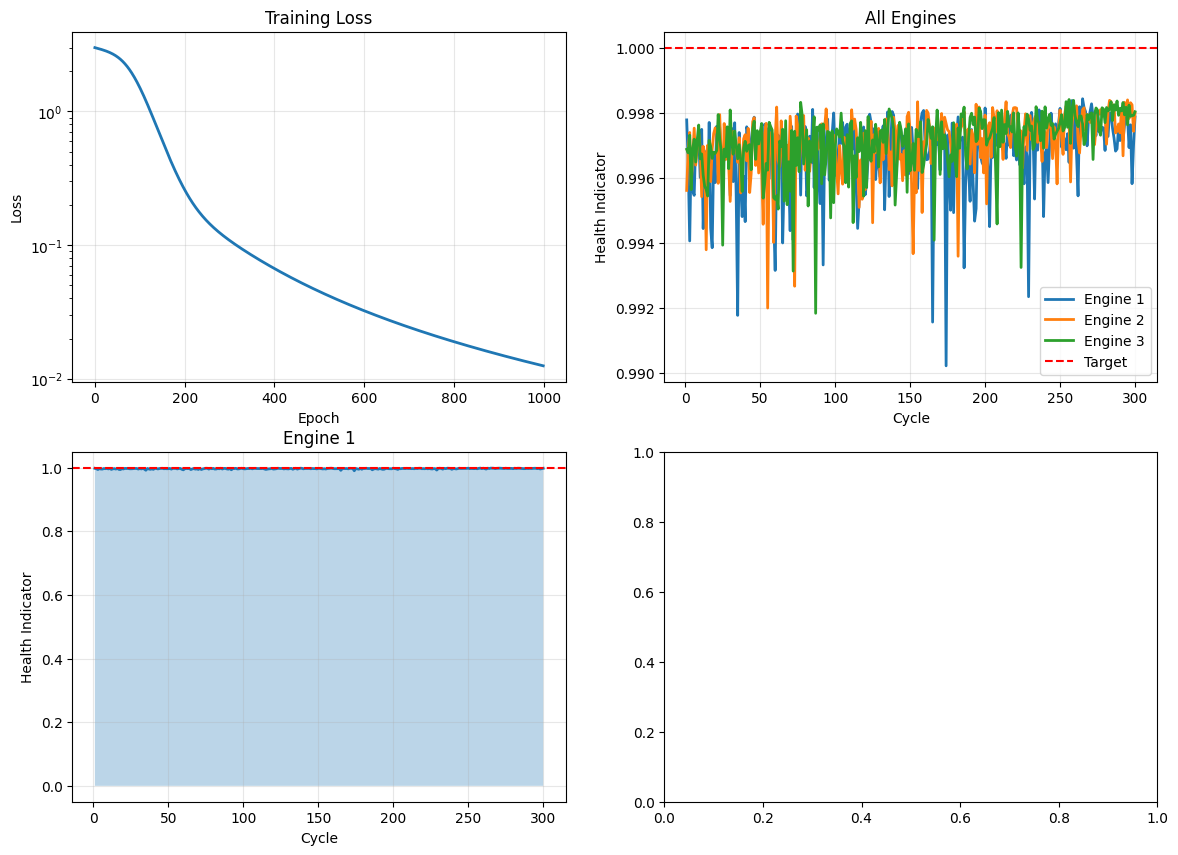

In [20]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curve
axes[0, 0].plot(loss_history, linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# All engines HI
for i, pred in enumerate(predictions):
    cycles = np.arange(1, len(pred) + 1)
    axes[0, 1].plot(cycles, pred, linewidth=2, label=f'Engine {i+1}')
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', label='Target')
axes[0, 1].set_xlabel('Cycle')
axes[0, 1].set_ylabel('Health Indicator')
axes[0, 1].set_title('All Engines')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Engine 1 detail
cycles = np.arange(1, len(predictions[0]) + 1)
axes[1, 0].plot(cycles, predictions[0], linewidth=2)
axes[1, 0].axhline(y=1.0, color='red', linestyle='--')
axes[1, 0].fill_between(cycles, predictions[0], alpha=0.3)
axes[1, 0].set_xlabel('Cycle')
axes[1, 0].set_ylabel('Health Indicator')
axes[1, 0].set_title('Engine 1')
axes[1, 0].grid(True, alpha=0.3)

# Final HI comparison
final_HI = [pred[-1] for pred in predictions]
engine_labels = [f'E{i+1}' for i in range(N)]
axes[1, 1].bar(engine_labels, final_HI, alpha=0.8)
axes[1, 1].axhline(y=1.0, color='red', linestyle='--')
axes[1, 1].set_ylabel('Final HI')
axes[1, 1].set_title('Final Health Indicators')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()